In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from utils import *

plt.rcParams["figure.figsize"] = (5,5)

In [2]:
img_path = 'testIm.jpeg'

# LP detect

In [3]:
LP_model = cv2.dnn.readNet('lp_detection/yolov4-tiny-lp-det_best.weights', 'lp_detection/yolov4-tiny-lp-det.cfg')

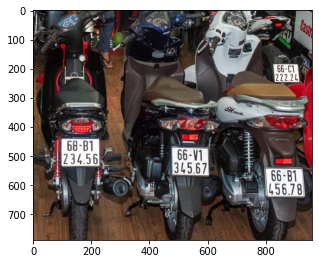

In [4]:
in_img = cv2.imread(img_path)
height, width = in_img.shape[:2]
plt.imshow(cv2.cvtColor(in_img, cv2.COLOR_BGR2RGB))

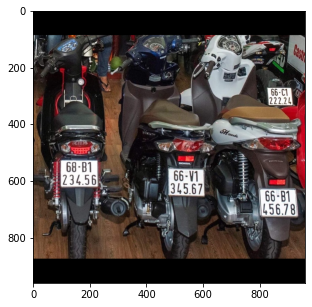

In [5]:
in_img = fit_to_square(in_img, size=max(in_img.shape[:2]))
plt.imshow(cv2.cvtColor(in_img, cv2.COLOR_BGR2RGB))

In [6]:
blob = cv2.dnn.blobFromImage(in_img, 1/255.0, (416,416), 0, swapRB=True, crop=False)
LP_model.setInput(blob)
output_layers_name = LP_model.getUnconnectedOutLayersNames()
layeroutput = LP_model.forward(output_layers_name)

In [7]:
CONFI_THRES = 0.5

confidences = []
boxes = []
class_ids = []
bboxes_yolo = []

for output in layeroutput:
    for detection in output:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = float(scores[class_id])
        if confidence > CONFI_THRES:
            center_x = int(detection[0] * width)
            center_y = int(detection[1] * height)
            detected_width = int(detection[2] * width)
            detected_height = int(detection[3] * height)

            x_min = int(center_x - detected_width / 2)
            y_min = int(center_y - detected_height / 2)

            boxes.append([x_min, y_min, detected_width, detected_height])
            bboxes_yolo.append(detection[:4])
            confidences.append(confidence)
            class_ids.append(class_id)

indexes = cv2.dnn.NMSBoxes(boxes, confidences, score_threshold=CONFI_THRES, nms_threshold=0.4)

In [8]:
license_plates = []
license_plates_crop_resize = []

if len(indexes) > 0:
    for i in indexes.flatten():
        crop = crop_im(in_img, bboxes_yolo[i])

        crop_resize = resize_with_ratio(crop, 100/crop.shape[1])
        blr = cv2.GaussianBlur(crop_resize, (5,5), 1.0)
        license_plates.append(blr)

        crop_resize = cv2.resize(crop, (100, 100))
        blr = cv2.GaussianBlur(crop_resize, (5,5), 1.0)
        license_plates_crop_resize.append(blr)
        
        print(round(confidences[i], 2))

0.99
0.99
0.99
0.98


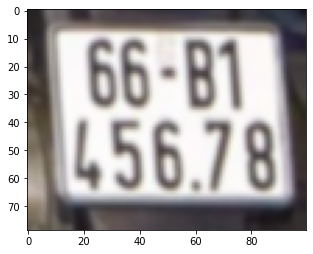

In [9]:
plt.imshow(license_plates[0])

# Character detect

In [10]:
char_det_model = cv2.dnn.readNet('character_detection/yolov4-tiny-char-detect_last.weights', 'character_detection/yolov4-tiny-char-detect.cfg')

In [11]:
lp_img = license_plates_crop_resize[0]
height, width = lp_img.shape[:2]

In [12]:
blob = cv2.dnn.blobFromImage(lp_img, 1/255.0, (416,416), 0, swapRB=True, crop=False)
char_det_model.setInput(blob)
output_layers_name = char_det_model.getUnconnectedOutLayersNames()
layeroutput = char_det_model.forward(output_layers_name)

In [13]:
CHAR_THRES = 0.7

confidences = []
boxes = []
bboxes_yolo = []

for output in layeroutput:
    for detection in output:
        confidence = float(detection[5])
        if confidence > CHAR_THRES:
            center_x = int(detection[0] * width)
            center_y = int(detection[1] * height)
            detected_width = int(detection[2] * width)
            detected_height = int(detection[3] * height)

            x_min = int(center_x - detected_width / 2)
            y_min = int(center_y - detected_height / 2)

            boxes.append([x_min, y_min, detected_width, detected_height])
            bboxes_yolo.append(detection[:4])
            confidences.append(confidence)

indexes = cv2.dnn.NMSBoxes(boxes, confidences, score_threshold=CHAR_THRES, nms_threshold=0.4)

In [14]:
lp_img = license_plates[0]
characters = []
char_centers = []

if len(indexes) > 0:
    for i in indexes.flatten():
        bbox = bboxes_yolo[i].copy()
        bbox[2] += 0.05
        bbox[3] += 0.05
        new_im = crop_im(lp_img, bbox)
        new_im = cv2.cvtColor(new_im, cv2.COLOR_BGR2GRAY)
        new_im = resize_with_ratio(new_im, 28/new_im.shape[0])
        border = 28-new_im.shape[1]
        if border % 2 == 0:
            border_L = border_R = border // 2
        else:
            border_L = border // 2
            border_R = border_L + 1
        new_im = cv2.copyMakeBorder(new_im, 0, 0, border_L, border_R, cv2.BORDER_REPLICATE)
        characters.append(new_im)
        print(round(confidences[i], 2))
    char_centers = [bboxes_yolo[i][:2] for i in indexes.flatten()]

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


# Character recognize

In [15]:
ALPHA_DICT = {0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9',
    10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'K', 19: 'L',
    20: 'M', 21: 'N', 22: 'P', 23: 'R', 24: 'S', 25: 'T', 26: 'U', 27: 'V', 28: 'X', 29: 'Y', 30: 'Z'}

In [16]:
reco_model = Sequential()
reco_model.add(Conv2D(64, (5, 5), padding='same', activation='relu', input_shape=(28, 28, 1)))
reco_model.add(BatchNormalization())
reco_model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
reco_model.add(BatchNormalization())
reco_model.add(MaxPooling2D(pool_size=(2, 2)))

reco_model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
reco_model.add(BatchNormalization())
reco_model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
reco_model.add(BatchNormalization())
reco_model.add(MaxPooling2D(pool_size=(2, 2)))

reco_model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
reco_model.add(BatchNormalization())
reco_model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
reco_model.add(BatchNormalization())
reco_model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
reco_model.add(BatchNormalization())
reco_model.add(MaxPooling2D(pool_size=(2, 2)))

reco_model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
reco_model.add(BatchNormalization())
reco_model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
reco_model.add(BatchNormalization())
reco_model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
reco_model.add(BatchNormalization())
reco_model.add(MaxPooling2D(pool_size=(2, 2)))

reco_model.add(Flatten())
reco_model.add(Dense(1024, activation='relu'))
reco_model.add(Dropout(0.5))
reco_model.add(Dense(31, activation='softmax'))

2021-10-05 16:37:33.815970: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-05 16:37:33.816351: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
reco_model.load_weights('character_recognition/myCNN_backup_28_BN_new.h5')

In [18]:
char_tensor = np.array(characters).reshape((len(characters), 28, 28, 1))
char_tensor = char_tensor / 255.0

In [19]:
result = reco_model.predict(char_tensor)
result = np.argmax(result, axis=1)

2021-10-05 16:37:34.257232: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


In [20]:
chars = [ALPHA_DICT[i] for i in result]

In [21]:
def format_LP(chars, char_centers):
    x = [c[0] for c in char_centers]
    y = [c[1] for c in char_centers]
    y_mean = np.mean(y)

    if y_mean - min(y) < 0.1:
        return [i for _, i in sorted(zip(x, chars))]
    
    sorted_chars = [i for _, i in sorted(zip(x, chars))]
    y = [i for _, i in sorted(zip(x, y))]
    first_line = [i for i in range(len(chars)) if y[i] < y_mean]
    second_line = [i for i in range(len(chars)) if y[i] > y_mean]
    return [sorted_chars[i] for i in first_line] + ['-'] + [sorted_chars[i] for i in second_line]

In [22]:
final_lab = ''.join(format_LP(chars, char_centers))

# Result

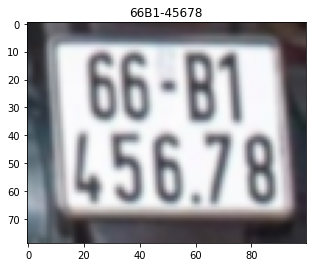

In [23]:
plt.imshow(cv2.cvtColor(license_plates[0], cv2.COLOR_BGR2RGB))
plt.title(final_lab)
plt.show()